In [1]:
 !pip install tensorflow==2.10.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 594.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 90.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 84.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 38.8 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attemp

In [2]:
! python -V

Python 3.10.12


In [3]:
!pip install albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.0/224.0 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 24.9 MB/s eta 0:00:00


In [41]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import os
import random
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
import matplotlib.cm as cm

import albumentations as A

In [5]:
tf.__version__

'2.10.0'

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# 시드 값 설정
SEED = 50

# 시드 고정
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [17]:
normal_dir = '/content/drive/MyDrive/캡스톤/Data_2/Normal'
abnormal_dir = '/content/drive/MyDrive/캡스톤/Data_2/Abnormal'

# 이미지 파일 리스트 생성
normal_images = [os.path.join(normal_dir, fname) for fname in os.listdir(normal_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))]
abnormal_images = [os.path.join(abnormal_dir, fname) for fname in os.listdir(abnormal_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))]

# 데이터 셋 셔플
random.shuffle(normal_images)
random.shuffle(abnormal_images)

# 정상 데이터 분할
normal_train, normal_temp = train_test_split(normal_images, test_size=0.3, random_state=42)
normal_val, normal_test = train_test_split(normal_temp, test_size=0.5, random_state=42)

# 비정상 데이터 분할
abnormal_train, abnormal_temp = train_test_split(abnormal_images, test_size=0.1, random_state=42) #normal_temp의 수와 비슷하게 0.1로 조정
abnormal_val, abnormal_test = train_test_split(abnormal_temp, test_size=0.5, random_state=42)

# 데이터셋 통합
train_data = normal_train + abnormal_train
train_labels = [0] * len(normal_train) + [1] * len(abnormal_train)

val_data = normal_val + abnormal_val
val_labels = [0] * len(normal_val) + [1] * len(abnormal_val)

test_data = normal_test + abnormal_test
test_labels = [0] * len(normal_test) + [1] * len(abnormal_test)

# 데이터셋 섞기
train_dataset = list(zip(train_data, train_labels))
random.shuffle(train_dataset)
train_data, train_labels = zip(*train_dataset)

val_dataset = list(zip(val_data, val_labels))
random.shuffle(val_dataset)
val_data, val_labels = zip(*val_dataset)

test_dataset = list(zip(test_data, test_labels))
random.shuffle(test_dataset)
test_data, test_labels = zip(*test_dataset)

# 이미지 전처리 및 데이터 증강 정의
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# 레이블을 문자열로 변환
train_labels = ['Normal' if label == 0 else 'Abnormal' for label in train_labels]
val_labels = ['Normal' if label == 0 else 'Abnormal' for label in val_labels]
test_labels = ['Normal' if label == 0 else 'Abnormal' for label in test_labels]

# train, val, test 데이터셋을 ImageDataGenerator의 flow 메서드를 통해 불러오기
def path_label_to_dataframe(paths, labels):
    return pd.DataFrame({'filename': paths, 'class': labels})

train_df = path_label_to_dataframe(train_data, train_labels)
val_df = path_label_to_dataframe(val_data, val_labels)
test_df = path_label_to_dataframe(test_data, test_labels)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)



Found 848 validated image filenames belonging to 2 classes.
Found 71 validated image filenames belonging to 2 classes.
Found 71 validated image filenames belonging to 2 classes.


기존코드

In [18]:
# ResNet50 모델 구성
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # 이진 분류이므로 출력 노드는 1개, sigmoid 활성화 함수 사용
])

# 모델 컴파일 (Learning Rate 조정 없이 기본 설정 사용)
optimizer = tf.keras.optimizers.Adam()  # 기본 Learning Rate = 0.001
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# 체크포인트 콜백
checkpoint = ModelCheckpoint('best_resnet_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# 클래스 가중치 계산
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = dict(enumerate(class_weights))

94765736/94765736 [==============================] - 0s 0us/step


In [20]:
# 모델 학습
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    class_weight=class_weights_dict,
    callbacks=[checkpoint]
)

Epoch 1/100
27/27 [==============================] - ETA: 0s - loss: 0.2439 - accuracy: 0.9198 
Epoch 1: val_accuracy improved from -inf to 0.78873, saving model to best_resnet_model.h5
27/27 [==============================] - 357s 13s/step - loss: 0.2439 - accuracy: 0.9198 - val_loss: 0.4152 - val_accuracy: 0.7887
Epoch 2/100
27/27 [==============================] - ETA: 0s - loss: 0.1107 - accuracy: 0.9540
Epoch 2: val_accuracy improved from 0.78873 to 0.90141, saving model to best_resnet_model.h5
27/27 [==============================] - 22s 815ms/step - loss: 0.1107 - accuracy: 0.9540 - val_loss: 0.3214 - val_accuracy: 0.9014
Epoch 3/100
27/27 [==============================] - ETA: 0s - loss: 0.0989 - accuracy: 0.9670
Epoch 3: val_accuracy did not improve from 0.90141
27/27 [==============================] - 22s 809ms/step - loss: 0.0989 - accuracy: 0.9670 - val_loss: 0.3124 - val_accuracy: 0.9014
Epoch 4/100
27/27 [==============================] - ETA: 0s - loss: 0.0716 - accurac

In [22]:
# 평가
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

3/3 [==============================] - 13s 6s/step - loss: 8.0845e-04 - accuracy: 1.0000
Test Loss: 0.0008084450382739305, Test Accuracy: 1.0


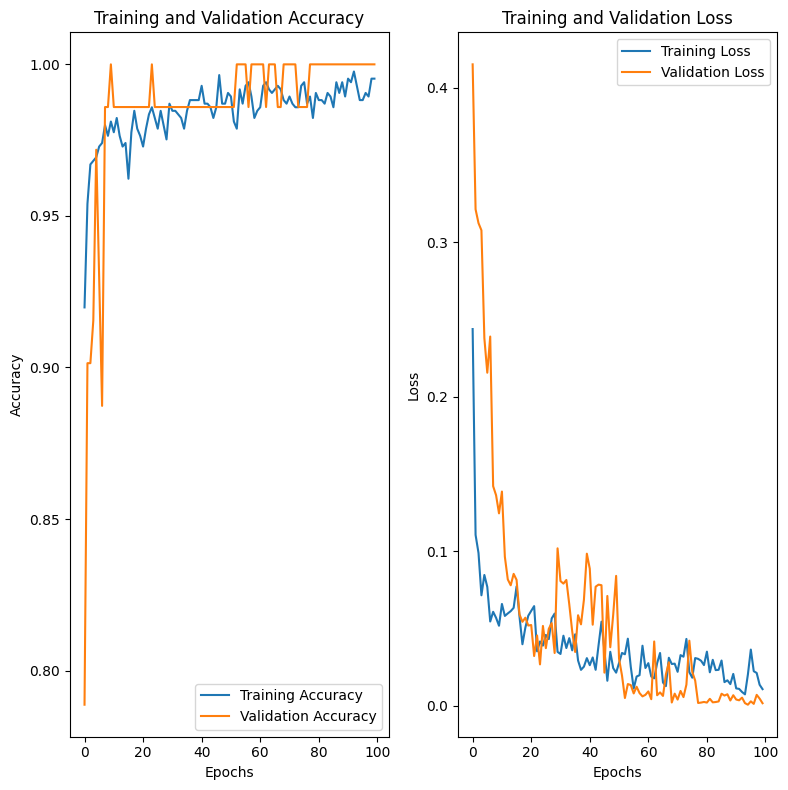

In [23]:
# 학습 결과 시각화
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# 그래프 그리기
plt.figure(figsize=(8, 8))

# Accuracy 그래프
plt.subplot(1, 2, 1)
plt.plot(range(len(acc)), acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(range(len(loss)), loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

3/3 [==============================] - 3s 349ms/step


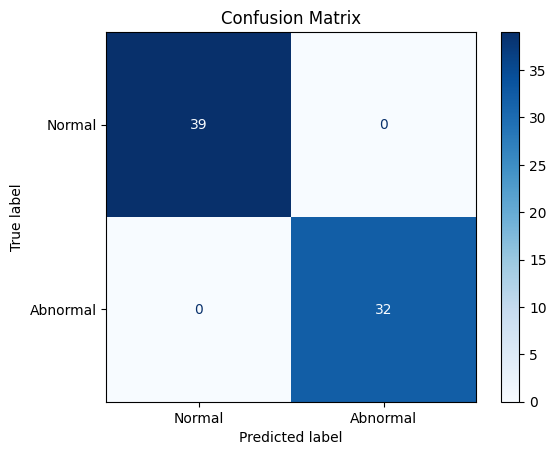

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# 테스트 데이터에 대한 예측
y_pred = model.predict(test_generator)
y_pred_classes = np.where(y_pred > 0.5, 1, 0)  # 0.5를 기준으로 이진 분류

# 실제 레이블과 예측된 레이블을 가져옴
y_true = test_generator.classes

# 혼동 행렬 계산
cm = confusion_matrix(y_true, y_pred_classes)

# 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Abnormal'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [25]:
model.save('trained_model_ResNet50.h5')

In [26]:
from google.colab import files
files.download('trained_model_ResNet50.h5')  # from colab to browser download

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>